In [1]:
import os, sys
from captcha.image import ImageCaptcha
import random
import string
from keras.utils import plot_model
import numpy as np
from tensorflow.keras.models import Sequential,Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout,Dense,MaxPooling2D,Flatten,Conv2D,Input,concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
#定义验证码大小，n_class,
height,width,batch_size,n_class = 50,100,48,10
#生成随机数
def get_code():
    raw = string.digits
#     + string.ascii_lowercase #小写
#     + string.ascii_uppercase#大写

    random_code = ''.join(random.sample(raw,4))
    return raw,random_code

#生成验证码
def generator(height,width,batch_size,n_class):
    X = np.zeros((batch_size,height,width,3))
    y = [np.zeros((batch_size,n_class),dtype=np.uint8) for i in range(4)]
    
    #验证码生成器
    generator = ImageCaptcha(height=height,width=width)
    while True:
        for i in range(batch_size):
            raw ,random_code = get_code()
            img = np.array((generator.generate_image(random_code)),dtype=np.float32)
            X[i] = img/255.0
            
            for j,ch in enumerate(random_code):
                y[j][i,:] = 0
                y[j][i,raw.find(ch)] = 1
        yield X,y

In [3]:
inputs = Input(shape=(height,width,3))
x = inputs
x = Conv2D(32,kernel_size=3,strides=1,activation='relu',padding='same')(x)
# x = keras.layers.BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Conv2D(64,kernel_size=3,strides=1,activation='relu',padding='same')(x)
# x = keras.layers.BatchNormalization()(x)
x = MaxPooling2D(2)(x)
# x = Conv2D(64,kernel_size=3,strides=1,activation='relu',padding='same')(x)
# x = MaxPooling2D(2)(x)
# x = Conv2D(128,kernel_size=3,strides=1,activation='relu',padding='same')(x)
# x = MaxPooling2D(2)(x)
# x = keras.layers.BatchNormalization()(x)
x = Flatten()(x)
predictions  = [Dense(10, activation='softmax',name='%d'%(i))(x) for i in range(4)]

model = Model(inputs=inputs, outputs=predictions)
# model.summary()
# plot_model(Model,to_file='model.png')
# plot_model(model, to_file='modle.png', show_shapes=True)

In [5]:
adam = keras.optimizers.RMSprop()
model.compile(
            optimizer=adam,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cp_callback = keras.callbacks.ModelCheckpoint('./logs/'+'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                              save_best_only=True,save_weights_only=True,verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.2,patience=5, min_lr=0.001) #loss不下降，降低学习率
reduce_tr = keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=0, mode='auto')

model.fit_generator(generator(height,width,batch_size,n_class),
                    epochs=80,
                    steps_per_epoch=100,
                    validation_data=generator(height,width,batch_size,n_class),
                    validation_steps=5,
                    callbacks=[cp_callback,reduce_lr,reduce_tr])

model.save_weights('./logs/'+'last.h5')

Train for 100 steps, validate for 5 steps
Epoch 1/80
 99/100 [============================>.] - ETA: 0s - loss: 6.0251 - 0_loss: 1.3424 - 1_loss: 1.7367 - 2_loss: 1.6369 - 3_loss: 1.3090 - 0_accuracy: 0.5718 - 1_accuracy: 0.4251 - 2_accuracy: 0.4556 - 3_accuracy: 0.5995
Epoch 00001: val_loss improved from inf to 5.50702, saving model to ./logs/ep001-loss6.019-val_loss5.507.h5
100/100 [==============================] - 47s 474ms/step - loss: 6.0194 - 0_loss: 1.3398 - 1_loss: 1.7351 - 2_loss: 1.6352 - 3_loss: 1.3092 - 0_accuracy: 0.5725 - 1_accuracy: 0.4258 - 2_accuracy: 0.4558 - 3_accuracy: 0.5996 - val_loss: 5.5070 - val_0_loss: 1.2143 - val_1_loss: 1.6627 - val_2_loss: 1.5373 - val_3_loss: 1.0927 - val_0_accuracy: 0.6583 - val_1_accuracy: 0.5042 - val_2_accuracy: 0.4750 - val_3_accuracy: 0.6833
Epoch 2/80
 99/100 [============================>.] - ETA: 0s - loss: 5.3343 - 0_loss: 1.0987 - 1_loss: 1.5841 - 2_loss: 1.5114 - 3_loss: 1.1400 - 0_accuracy: 0.6688 - 1_accuracy: 0.4762 - 2_ac

Epoch 12/80
 99/100 [============================>.] - ETA: 0s - loss: 3.1932 - 0_loss: 0.4235 - 1_loss: 1.1367 - 2_loss: 0.9876 - 3_loss: 0.6454 - 0_accuracy: 0.8864 - 1_accuracy: 0.6673 - 2_accuracy: 0.7155 - 3_accuracy: 0.8251
Epoch 00012: val_loss did not improve from 2.43233
100/100 [==============================] - 45s 452ms/step - loss: 3.1908 - 0_loss: 0.4218 - 1_loss: 1.1353 - 2_loss: 0.9902 - 3_loss: 0.6435 - 0_accuracy: 0.8867 - 1_accuracy: 0.6683 - 2_accuracy: 0.7154 - 3_accuracy: 0.8256 - val_loss: 2.5205 - val_0_loss: 0.3211 - val_1_loss: 0.9461 - val_2_loss: 0.8253 - val_3_loss: 0.4280 - val_0_accuracy: 0.9375 - val_1_accuracy: 0.7708 - val_2_accuracy: 0.7708 - val_3_accuracy: 0.8708
Epoch 13/80
 99/100 [============================>.] - ETA: 0s - loss: 3.0299 - 0_loss: 0.4258 - 1_loss: 1.1007 - 2_loss: 0.9437 - 3_loss: 0.5597 - 0_accuracy: 0.8872 - 1_accuracy: 0.6644 - 2_accuracy: 0.7153 - 3_accuracy: 0.8445
Epoch 00013: val_loss improved from 2.43233 to 2.41896, savin

 99/100 [============================>.] - ETA: 0s - loss: 2.7805 - 0_loss: 0.3316 - 1_loss: 1.0420 - 2_loss: 0.8619 - 3_loss: 0.5450 - 0_accuracy: 0.9141 - 1_accuracy: 0.6886 - 2_accuracy: 0.7496 - 3_accuracy: 0.8651
Epoch 00023: val_loss did not improve from 1.90162
100/100 [==============================] - 45s 449ms/step - loss: 2.7749 - 0_loss: 0.3344 - 1_loss: 1.0404 - 2_loss: 0.8594 - 3_loss: 0.5407 - 0_accuracy: 0.9133 - 1_accuracy: 0.6883 - 2_accuracy: 0.7500 - 3_accuracy: 0.8665 - val_loss: 2.1314 - val_0_loss: 0.2526 - val_1_loss: 0.9067 - val_2_loss: 0.7110 - val_3_loss: 0.2611 - val_0_accuracy: 0.9083 - val_1_accuracy: 0.7333 - val_2_accuracy: 0.7917 - val_3_accuracy: 0.9125
Epoch 24/80
 99/100 [============================>.] - ETA: 0s - loss: 2.7785 - 0_loss: 0.2978 - 1_loss: 1.0484 - 2_loss: 0.8854 - 3_loss: 0.5470 - 0_accuracy: 0.9184 - 1_accuracy: 0.6898 - 2_accuracy: 0.7536 - 3_accuracy: 0.8674
Epoch 00024: val_loss did not improve from 1.90162
100/100 [=============

 99/100 [============================>.] - ETA: 0s - loss: 2.4217 - 0_loss: 0.2530 - 1_loss: 0.9223 - 2_loss: 0.7807 - 3_loss: 0.4657 - 0_accuracy: 0.9360 - 1_accuracy: 0.7214 - 2_accuracy: 0.7740 - 3_accuracy: 0.8853
Epoch 00034: val_loss did not improve from 1.66128
100/100 [==============================] - 45s 449ms/step - loss: 2.4126 - 0_loss: 0.2528 - 1_loss: 0.9198 - 2_loss: 0.7780 - 3_loss: 0.4619 - 0_accuracy: 0.9362 - 1_accuracy: 0.7212 - 2_accuracy: 0.7744 - 3_accuracy: 0.8865 - val_loss: 1.7215 - val_0_loss: 0.1936 - val_1_loss: 0.7655 - val_2_loss: 0.5713 - val_3_loss: 0.1910 - val_0_accuracy: 0.9542 - val_1_accuracy: 0.7667 - val_2_accuracy: 0.8583 - val_3_accuracy: 0.9458
Epoch 35/80
 99/100 [============================>.] - ETA: 0s - loss: 2.4624 - 0_loss: 0.2347 - 1_loss: 0.9382 - 2_loss: 0.8031 - 3_loss: 0.4864 - 0_accuracy: 0.9428 - 1_accuracy: 0.7275 - 2_accuracy: 0.7731 - 3_accuracy: 0.8855
Epoch 00035: val_loss did not improve from 1.66128
100/100 [=============

验证代码

In [6]:
import matplotlib.pyplot as plt#画图
#定义验证码大小，n_class,
height,width,batch_size,n_class = 50,100,1,10
#生成随机数
def get_code():
    raw = string.digits
#     + string.ascii_lowercase #小写
#     + string.ascii_uppercase#大写

    random_code = ''.join(random.sample(raw,4))
    return raw,random_code

#生成验证码
def generator(height,width,batch_size,n_class):
    X = np.zeros((batch_size,height,width,3))
    y = [np.zeros((batch_size,n_class),dtype=np.uint8) for i in range(4)]
    
    #验证码生成器
    generator = ImageCaptcha(height=height,width=width)
    while True:
        for i in range(batch_size):
            raw ,random_code = get_code()
            image= generator.generate_image(random_code)
#             plt.imshow(image)
#             plt.title('random_str')
#             pylab.show()
            img = np.array((generator.generate_image(random_code)),dtype=np.float32)
            X[i] = img/255.0
            
            for j,ch in enumerate(random_code):
                y[j][i,:] = 0
                y[j][i,raw.find(ch)] = 1
        yield X,y,image

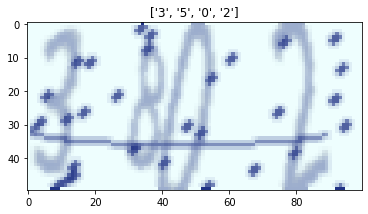

In [20]:
import pylab
X,y,image = next(generator(height,width,1,n_class))
y_pred = model.predict(X)
pred = np.argmax(y_pred,axis=-1)
a = '0,1,2,3,4,5,6,7,8,9'
list = []
for i in str(pred):
    if i in a :
        list.append(i)
# pred = str(pred)
# print(list)
plt.imshow(image)
plt.title(list)
pylab.show()